In [1]:
!apt install swi-prolog
!pip install pyswip

E: Não foi possível abrir arquivo de trava /var/lib/dpkg/lock-frontend - open (13: Permissão negada)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [2]:
import json
import random as rd
import time
from IPython.display import clear_output

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot,transforms
from pyswip import Prolog


# Map Settings

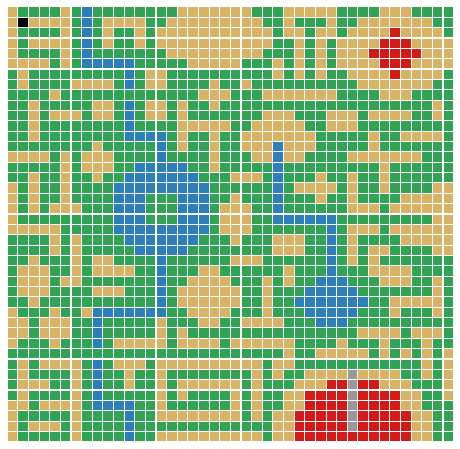

In [11]:
class Map:
  number_mall = 15
  number_pokecenter = 20
  number_trainers = 50
  number_pokemons = 150

  def __init__(self, name, size=42):
    self.name = name
    self.size = size
    self.pokemons = []
    self.matrix = []
    self.transformed_matrix = []
    self.dict = {}
  
  def load_map(self, to_print=False):  
    with open('./' + self.name, 'r') as map_file:
      for i in range(self.size):
        tmp = map_file.readline()
        if tmp[-1] == '\n':
          tmp = tmp[:-1]        
        self.matrix.append(tmp)
    if to_print:
      print('\n'.join(map(str, self.matrix)))
    self.refresh_map()

  def load_pokelist(self):
    with open('./pokemons.json','r') as pokes_file:
      self.pokemons = json.load(pokes_file)
  
  def print_dict_map(self):
    for keys,values in self.dict.items():
      print(keys, "=>", values)

  def draw_items(self, quantity, item):
    for i in range(quantity):
      while True:
        pos_x = rd.randint(0, self.size - 1)
        pos_y = rd.randint(0, self.size - 1)
        tmp = (pos_x, pos_y)
        if not tmp in self.dict:
          self.dict[tmp] = item
          break

  def draw_pokemons(self, quantity):
    for i in range(quantity):
      while True:
        pos_x = rd.randint(0, self.size - 1)
        pos_y = rd.randint(0, self.size - 1)
        tmp = (pos_x, pos_y)
        if not tmp in self.dict:
          self.dict[tmp] = i + 1
          break

  def set_map_elements(self, to_print=False):
    rd.seed = 123
  
    self.draw_items(self.number_mall, 'L')
    self.draw_items(self.number_pokecenter, 'P')
    self.draw_items(self.number_trainers, 'T')
    self.draw_pokemons(self.number_pokemons)
    
    if to_print:
      self.print_dict_map()
  
  def refresh_map(self):
    self.transformed_matrix = [[ord(self.matrix[j][i]) if ord(self.matrix[j][i]) != 67 else 68 for i in range(42)] for j in range(42)]
    
  
  def print(self, pos):
    clear_output(True)
    time.sleep(0.5)

    
    self.refresh_map()
    map_display =  self.transformed_matrix

    x = pos[0]
    y = pos[1]


    map_display[x][y] = 83

    my_colors = ['#2c7fb8','#999999','#31a354','#000001','#000001','#d8b365','#d8b365','#d8b365','#000000','#d41919']
    cmap = LinearSegmentedColormap.from_list('Custom', my_colors,len(my_colors))
    plt.figure(figsize=(8,8))
    
    heat_map = sns.heatmap(map_display, xticklabels=False, yticklabels=False, cbar=False, cmap=cmap, linecolor='white',linewidths=0.1)

    plt.show()


map = Map('map.txt')

map.load_map()
map.load_pokelist()
map.set_map_elements()
#print de teste
map.print((1,1))


# Agente

In [8]:
# Aqui começa a brincadeira
from pyswip import Prolog

class BaseQuery:
  def __init__(self, base_name = "base.pl"):
    self.prolog = Prolog()
    self.prolog.consult(base_name)
    self.prolog.retractall('pokemon(_)')
    self.prolog.retractall('mapaEntidades(_,_,_)')
    self.prolog.retractall('mapaPontos(_, _, _)')
    self.prolog.retractall('mapa(_, _, _)')
    self.prolog.retractall('tipo(_, _)')
    
  def insert_fact(self, fact):
    list(self.prolog.query(f"not({fact}), assert({fact})"))

  def print_list(self, list):
    for item in list:
      for key in item:
        print(key, "=", item[key])
    # if len(list) > 0:
    #   print("\n\nyes.\n\n")
    # else:
    #   print("\n\nno.\n\n")

  def query(self, query, print=False):
    result = list(self.prolog.query(query))
    if print:
      self.print_list(result)
    return result
  
  def insert_map_facts(self):
    for i in range(42):
      for j in range(42):
        if map.matrix[i][j] == 'A':
          self.insert_fact(f"mapa({i}, {j}, agua)")
        elif map.matrix[i][j] == 'G':
          self.insert_fact(f"mapa({i}, {j}, grama)")
        elif map.matrix[i][j] == 'V':
          self.insert_fact(f"mapa({i}, {j}, vulcao)")
        elif map.matrix[i][j] == 'M':
          self.insert_fact(f"mapa({i}, {j}, montanha)")
        elif map.matrix[i][j] == 'C':
          self.insert_fact(f"mapa({i}, {j}, caverna)")


  def insert_entity_fact(self, i, j):
    if (i < 42 and j < 42 and len(self.query(f"mapaEntidades({i}, {j}, _)")) == 0):
      tmp = (i, j)
      entity = map.dict.get(tmp, "VAZIO")

      if entity == 'L':
        base.insert_fact(f"mapaEntidades({i}, {j}, loja)")
      elif entity == 'P':
        base.insert_fact(f"mapaEntidades({i}, {j}, centroPokemon)")
      elif entity == 'T':
        base.insert_fact(f"mapaEntidades({i}, {j}, treinador)")
      elif isinstance(entity, int):
        name = map.pokemons[entity]["name"]["english"]
        base.insert_fact(f"mapaEntidades({i}, {j}, pokemon(\'" + name + "\'))")
    
        poke_types = map.pokemons[entity]["type"]
        for poke_type in poke_types:
          base.insert_fact(f"tipo({name}, {poke_type})")

  def insert_entity_fact_tile(self):
    locale = self.query("localizacao(Line, Column)")[0]
    self.insert_entity_fact(locale["Line"] + 1, locale["Column"])
    self.insert_entity_fact(locale["Line"] + -1, locale["Column"])
    self.insert_entity_fact(locale["Line"], locale["Column"] + 1)
    self.insert_entity_fact(locale["Line"], locale["Column"] - 1)
  
  def locale(self):
    locale = self.query("localizacao(Line, Column)")[0]
    map.print((locale["Line"], locale["Column"]))
  
  def pokemons(self):
    self.query("pokemon(Pokemon)", True)
  
  def score(self):
    self.query("pontos(Score)", True)
  
  def tile_score(self):
    locale = base.query("localizacao(Line, Column)")[0]
    line = locale["Line"]
    column = locale["Column"]

    self.query(f"mapaPontos({line - 1}, {column}, Cima)", True)
    self.query(f"mapaPontos({line + 1}, {column}, Baixo)", True)
    self.query(f"mapaPontos({line}, {column + 1}, Direita)", True)
    self.query(f"mapaPontos({line}, {column - 1}, Esquerda)", True)
  
  def balls(self):
    self.query("pokebolas(Balls)", True)
  
  def pokemons_count(self):
    return self.query("pokemonsCapturados(PokemonsCount)", True)[0]["PokemonsCount"]
  
  def query_types(self):
    self.query("tipo(_, Type)", True)
    

base = BaseQuery()

base.insert_map_facts()

while base.pokemons_count() < 150:
  base.insert_entity_fact_tile()
  base.score()
  base.balls()
  base.pokemons_count()
  # base.query_types()
  # base.pokemons()
  #base.locale()
  base.query("acao")

print("END GAME")


KeyboardInterrupt: 